# Предсказание цен на недвижимость

Задачей проекта является построение модель для предсказания цен на недвижимость

Ключевая метрика - R^2

Исходные данные состоят из 3 файлов:
1. Данные для обучения - train.csv
2. Тестовые данные - test.csv
3. Файл для созранения предсказаний с id квартир - sample_submission.csv

Ссылка на проект:
https://www.kaggle.com/c/real-estate-price-prediction-moscow

# Оглавление <a class="anchor" id="0-bullet"></a>

* [Загрузка и подготовка данных](#1-bullet)
* [Обучение модели](#2-bullet)
* [Тестирование модели](#3-bullet)

# 1. Загрузка и подготовка данных  <a class="anchor" id="1-bullet"></a>
[Обратно в оглавление](#0-bullet)

Подключение библиотек

In [37]:
#Работа с DataFrame
import pandas as pd
!{sys.executable} -m pip install pandas-profiling
import pandas_profiling 
#Работа с массивами
import numpy as np
#Графики
import matplotlib.pyplot as plt
import seaborn as sns
#Заполнение пропусков
from random import *
#Разделение выборки
from sklearn.model_selection import train_test_split
#Нормирование
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
#Обучение моделей
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
#XGBoost
!pip install xgboost 
import xgboost as xgb
from xgboost import XGBRegressor
#Метрика R2
from sklearn.metrics import r2_score
#Отмена вывода предупреждений
import warnings

"{sys.executable}" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Открытие файлов

In [38]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Посмотрим, на основе каких данных будем строить прогнозы

In [39]:
display(train_data.head(3))
pandas_profiling.ProfileReport(train_data).to_file('Report_train.html')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Данные содержат следующие колонки:
* Район
* Количество комнат
* Площадь (Общая, жилая, плоащадь кухни)
* Этаж, Количество этажей в доме
* Год постройки дома
* Оценка экологии (Ecology) (3 столбца, первый - оценка в числовом значении, второй и третий - класс экологичности)
* Оценка окружения (Social) (3 столбца, первый и второй - оценка в числовом значении, третий - класс окружения)
* Оценка здравоохранения (Healthcare) (2 столбца, первый - оценка в числовом значении, второй - класс здравоохранения)
* Нличие магазинов (Shops) (2 столбца, первый - булевый с наличием магазинов, второй - класс магазинов)
* Цена кваритры

Посмотрим на пропуски в данных

In [4]:
display(train_data.info())
display(test_data.info())
display(sample_submission.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


None

Тестовая выборка и обучающая выборка содержит пропуски. В тестовой выборке не будем работать  пропусками, как в реальном проектае, а в обучающей выборке заполним пропуски. 
Количество пропусков в обучающей выборке:
* Жилая площадь (LifeSquare): 2113, 21% от общего количества
* Числовое значение для здравоохранения (Healthcare_1): 4798, 48% от общего количества

### Заполнение пропусков
* Для заполнения жилой площади создадим новый столбец: 

$other__square = Общая__площадь - Жилая__площадь - Площадь__кухни$


other_square - это площадь коридоров, ванной комнаты, санузла, балконов. Затем заполним пропуски в other_square из-за пропусков в жилой площади средним значением в зависимости от количества комнат. Последним шагом расчитаем жилую площадь 

$Жилая__площадь = Общая__площадь - Площадь__кухни - other__square$


* Для Healthcare_1 не понимаем взаимосвязь, поэтому заполним случайно от минимума до максимума, чтобы не смещать выборку

In [5]:
#Создание столбца - Остальная площадь
train_data['other_square'] = train_data['Square'] - train_data['LifeSquare'] - train_data['KitchenSquare']
#Заполнение остальной плоащди по средними, сгруппированными по количеству комнат
train_data['other_square'] = train_data['other_square'].fillna(train_data.groupby('Rooms')['other_square'].
                                                                     transform('mean'))
#Заполнение пропусков в жилой площади
#train_data['LifeSquare_2'] = train_data['Square'] - train_data['other_square'] - train_data['KitchenSquare']
train_data['LifeSquare'] = train_data['Square'] - train_data['other_square'] - train_data['KitchenSquare']
#Удалим столбец other_square, так как он уже не нужен
train_data = train_data.drop(columns = ['other_square'])

In [6]:
#Заполнение пропусков в Healthcare_1
max_healthcare = train_data['Healthcare_1'].max()
min_healthcare = train_data['Healthcare_1'].min()
null_index = train_data[train_data['Healthcare_1'].isnull()].index
#display(null_index)
for i in null_index:
    train_data.loc[i,'Healthcare_1'] = randint(min_healthcare, max_healthcare)
#display(train_data.groupby('Healthcare_1')['Healthcare_1'].count())

Проверка пропусков

In [7]:
train_data[train_data.isnull() == True].count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [8]:
#Группировка остальной площади по количеству комнат
#other_group = round(train_data.groupby('Rooms')['other_square'].mean(),2)
#display(other_group)

In [9]:
train_data[train_data['LifeSquare'].isnull() == True].groupby('Rooms').mean()

,Id,DistrictId,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Rooms,,,,,,,,,,,,,,,,


Построим матрицу корреляций для признаков, чтобы выявить сильнокоррелирующие признаки. Исключение таких признаков решит проблему с мультиколлинеарностью

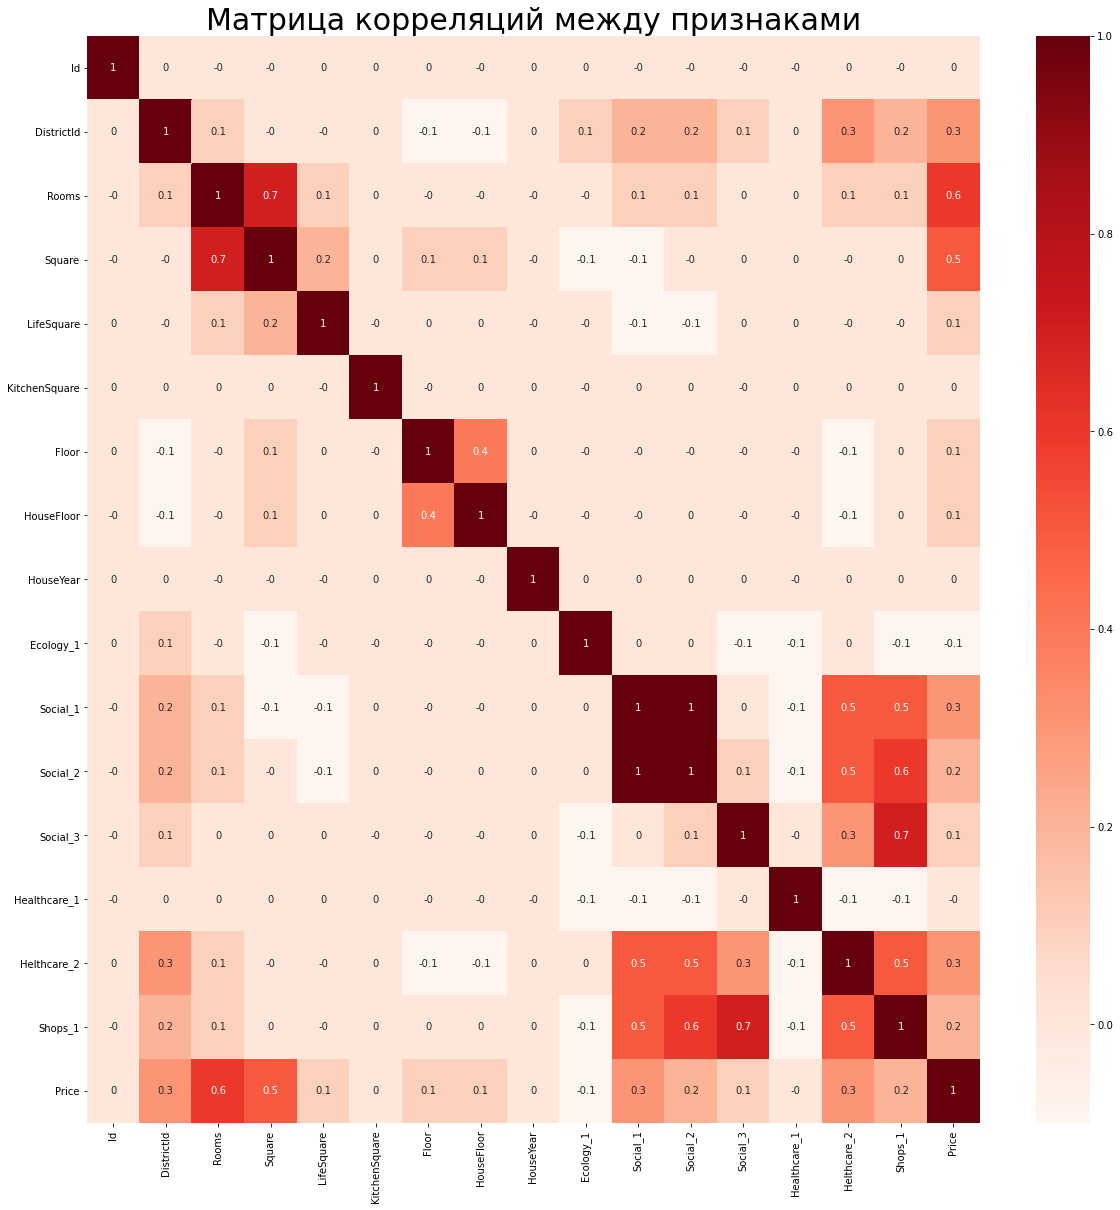

In [10]:
plt.figure(figsize=(20,20))
cor = round(train_data.corr(),1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Матрица корреляций между признаками', fontsize=30)
plt.show()

* Social_1 и Social_2 имеют корреляцию в 1, исключим Social_2 из признаков
* Высокая корреляция между количеством комнат (Rooms) и общей площадью (Square) = 0.7. Чем больше комнат, тем больше площадь и наоборот
* А также между Shops_1 и Social_3. Гиотеза в том, что social_3 и shops_1 содержат переменную, которая оказывет благоприятное влияние на общественную жизнь и на наличие магазинов рядом. Это может быть близость к метро, торговый центр и т.д.

#### Для дальнейшего анализа сделаем 2 дополнительных набора данных:
1. train_data_light: Исключим Social_2
2. train_data_hard: Исключим Social_2, Social_3, Square

Также из каждого датасета удалим столбец с id и столбцы, которые не содержатся в тестовых данных: Ecology_2, Ecology_3

In [11]:
print(train_data.columns)
print(test_data.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')
Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')


In [12]:
train_data = train_data.drop(columns=['Id'])
train_data_light = train_data.drop(columns = ['Social_2'])
train_data_hard = train_data.drop(columns = ['Social_2','Social_3','Square'])

# 2. Обучение и проверка модели  <a class="anchor" id="2-bullet"></a>
[Обратно в оглавление](#0-bullet)

* Создадим дамми переменные для признаков Ecology_2, Ecology_3, Shops_2
* Разделим данные на обучающие и тестовые для дальнейшего нормирования количественных данных
* Сохраним нормированные данные в отдельных переменных, чтобы посмотреть, насколько нормирование улучшило модель
* Так как у нас 3 набора данных, то сделаем функцию для разделения и нормирования

In [13]:
def split (data):
    #Зададим random state для всего проекта
    random_state = 100500
    #Выделим целевую переменную
    x = data.drop('Price',axis=1)
    y = data['Price']
    #Создание дамми переменных
    x = pd.get_dummies(x, drop_first= True)
    #Разделение выборки
    x_train,x_valid,y_train,y_valid=train_test_split(x,y,test_size=0.2)
    return x_train,x_valid,y_train,y_valid

Нормализуем только данные, которые входят в 3 набора данных: 
* количество комнат
* жилая площадь
* кухонная площадь
* этаж
* этажность дома
* год постройки дома

In [14]:
def normalized (x_train,x_test):
    scaler = ColumnTransformer(transformers=[('scale',StandardScaler(),
    ['Rooms', 'LifeSquare', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear'])],remainder = 'passthrough')
    x_train_sc = scaler.fit_transform(x_train)
    #Нормируем тестовую выборку для использования в модели при тестировании
    x_test_sc = scaler.transform(x_test)
    return x_train_sc,x_test_sc

In [15]:
#Разделение
x_train,x_valid,y_train,y_valid = split(train_data)
x_train_l,x_valid_l,y_train_l,y_valid_l = split(train_data_light)
x_train_h,x_valid_h,y_train_h,y_valid_h = split(train_data_hard)
#Нормализация
x_train, x_test = normalized(x_train,x_valid)
x_train_l, x_test_l = normalized(x_train_l,x_valid_l)
x_train_h, x_test_h = normalized(x_train_h,x_valid_h)

In [16]:
def rsquared(y_pred,y_true):
    labels = y_true.get_label()
    sse = np.sum((labels-y_pred)**2)
    sst = np.sum((labels-np.mean(labels))**2)
    rsquared = 1 -sse/sst
    return 'r2',-rsquared

Есть три набора данных для обучения: 
1. Без удаления столбцов
2. С удалением столбцов с 100% корреляцией
3. С удалением столбцов с корреляцией больше 70%

Модель показала наилучший результат на втором наборе данных. Используем его

In [17]:
#Обозначим данные для XGBoost

#init
#x = train_data.drop('Price',axis=1)
#y = train_data['Price']

#light
x = train_data_light.drop('Price',axis=1)
y = train_data_light['Price']


#hard
#x = train_data_hard.drop('Price',axis=1)
#y = train_data_hard['Price']


In [18]:
x = pd.get_dummies(x, columns = ['DistrictId','Ecology_2','Ecology_3','Shops_2'], drop_first= True)
x_learn,x_test, y_learn,  y_test = train_test_split(x,y, test_size=0.2,random_state=100500)
x_train,x_valid,y_train,y_valid = train_test_split( x_learn, y_learn, test_size=0.25,random_state=100500)

dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)
dtest = xgb.DMatrix(x_test, label=y_test)
#Обозначим парметры для модели
params_xgboost = {
    'max_depth':9,
    'min_child_weight': 5,
    'eta':.2,
    'subsample': 1,
    'colsample_bytree': .7,
    'objective':'reg:linear',
    'disable_default_eval_metric':1
}
#params_xgboost['eval_metric'] = r_score(dvalid,y_valid)

num_boost_round = 30

In [19]:
warnings.filterwarnings('ignore')
#Обучим модель XGBoost
model = xgb.train(
    params_xgboost,
    dtrain,
    num_boost_round=num_boost_round,
    feval = rsquared,
    evals=[(dvalid, "Train")],
    early_stopping_rounds=10
)

[22:42:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Train-r2:3.14619
[1]	Train-r2:1.77894
[2]	Train-r2:0.91423
[3]	Train-r2:0.34268
[4]	Train-r2:-0.02926
[5]	Train-r2:-0.26900
[6]	Train-r2:-0.42515
[7]	Train-r2:-0.52552
[8]	Train-r2:-0.59389
[9]	Train-r2:-0.63931
[10]	Train-r2:-0.67117
[11]	Train-r2:-0.69404
[12]	Train-r2:-0.70764
[13]	Train-r2:-0.71482
[14]	Train-r2:-0.72117
[15]	Train-r2:-0.72683
[16]	Train-r2:-0.72918
[17]	Train-r2:-0.73158
[18]	Train-r2:-0.73336
[19]	Train-r2:-0.73516
[20]	Train-r2:-0.73491
[21]	Train-r2:-0.73580
[22]	Train-r2:-0.73635
[23]	Train-r2:-0.73697
[24]	Train-r2:-0.73889
[25]	Train-r2:-0.73983
[26]	Train-r2:-0.74047
[27]	Train-r2:-0.74020
[28]	Train-r2:-0.74121
[29]	Train-r2:-0.74136


In [20]:
print('R2 XGBoost = ',round(r2_score(model.predict(dtest), y_test),3))

R2 XGBoost =  0.604


Подбор параметров для XGBoost

In [21]:
params = {
    'max_depth':9,
    'min_child_weight': 5,
    'eta':.2,
    'subsample': 1,
    'colsample_bytree': .7,
    'objective':'reg:linear',
    'disable_default_eval_metric':1
    }

num_boost_round = 30

In [22]:
warnings.filterwarnings('ignore')
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]
min_r2 = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    #print("CV with max_depth={}, min_child_weight={}".format(
     #                        max_depth,
      #                       min_child_weight))

    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        #metrics={'rmse'},
       feval = rsquared,
        early_stopping_rounds=10
    )
    mean_r2 = cv_results['test-r2-mean'].min()
    boost_rounds = cv_results['test-r2-mean'].argmin()
    #print("\R2 {} for {} rounds".format(mean_r2, boost_rounds))
    if mean_r2 < min_r2:
        min_r2 = mean_r2
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, R2: {}".format(best_params[0], best_params[1], min_r2))
    

[22:42:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

In [23]:
params['max_depth'] = 9
params['min_child_weight'] = 5

In [24]:
warnings.filterwarnings('ignore')
gridsearch_params = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(7,11)]
    for colsample_bytree in [i/10. for i in range(7,11)]
]
min_r2 = float("Inf")
best_params = None
for subsample, colsample_bytree in reversed(gridsearch_params):
    #print("CV with subsample={}, colsample={}".format(
                          #   subsample,
                           #  colsample_bytree))
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        feval=rsquared,
        early_stopping_rounds=10
    )
    mean_r2 = cv_results['test-r2-mean'].min()
    boost_rounds = cv_results['test-r2-mean'].argmin()
    #print("\tRMSE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_r2 < min_r2:
        min_r2 = mean_r2
        best_params = (subsample,colsample_bytree)
print("Best params: {}, {}, R2: {}".format(best_params[0], best_params[1], min_r2))



[22:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

In [25]:
params['subsample'] = 1
params['colsample_bytree'] = 0.7

In [26]:
warnings.filterwarnings('ignore')
%time
min_r2 = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    #print("CV with eta={}".format(eta))
    params['eta'] = eta
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,feval = rsquared,early_stopping_rounds=10)
    mean_r2 = cv_results['test-r2-mean'].min()
    boost_rounds = cv_results['test-r2-mean'].argmin()
    print("\tR2 {} for {} rounds\n".format(mean_r2, boost_rounds))
    if mean_r2 < min_r2:
        min_r2 = mean_r2
        best_params = eta
print("Best params: {}, R2: {}".format(best_params, min_r2))

Wall time: 0 ns
[22:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 5.31 s
	R2 -0.7235488 for 25 rounds

[22:45:11] WARNING: C:/Users/Administrator/workspac

In [27]:
params['eta'] = .2

In [28]:
#Обучим модель XGBoost
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round, 
    feval = rsquared,
    evals=[(dvalid, "Train")],
    early_stopping_rounds=10
)

[22:45:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Train-r2:3.14619
[1]	Train-r2:1.77894
[2]	Train-r2:0.91423
[3]	Train-r2:0.34268
[4]	Train-r2:-0.02926
[5]	Train-r2:-0.26900
[6]	Train-r2:-0.42515
[7]	Train-r2:-0.52552
[8]	Train-r2:-0.59389
[9]	Train-r2:-0.63931
[10]	Train-r2:-0.67117
[11]	Train-r2:-0.69404
[12]	Train-r2:-0.70764
[13]	Train-r2:-0.71482
[14]	Train-r2:-0.72117
[15]	Train-r2:-0.72683
[16]	Train-r2:-0.72918
[17]	Train-r2:-0.73158
[18]	Train-r2:-0.73336
[19]	Train-r2:-0.73516
[20]	Train-r2:-0.73491
[21]	Train-r2:-0.73580
[22]	Train-r2:-0.73635
[23]	Train-r2:-0.73697
[24]	Train-r2:-0.73889
[25]	Train-r2:-0.73983
[26]	Train-r2:-0.74047
[27]	Train-r2:-0.74020
[28]	Train-r2:-0.74121
[29]	Train-r2:-0.74136


In [29]:
print('R2 XGBoost = ',round((r2_score(model.predict(dtest), y_test)),4))

R2 XGBoost =  0.6042


Построим график предсказаний на обучающей и валидационной выборке

Сделаем функцию для отрисовки графика

In [30]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

In [31]:
#y_train_preds = stack.predict(x_train)
#y_test_preds = stack.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# 3. Тестирование модели  <a class="anchor" id="3-bullet"></a>
[Обратно в оглавление](#0-bullet)

In [32]:
#Заполнение пропусков для тестовых данных

#Создание столбца - Остальная площадь
test_data['other_square'] = test_data['Square'] - test_data['LifeSquare'] - test_data['KitchenSquare']
#Заполнение остальной плоащди по средними, сгруппированными по количеству комнат
test_data['other_square'] = test_data['other_square'].fillna(test_data.groupby('Rooms')['other_square'].
                                                                     transform('mean'))
#Заполнение пропусков в жилой площади
#train_data['LifeSquare_2'] = train_data['Square'] - train_data['other_square'] - train_data['KitchenSquare']
test_data['LifeSquare'] = test_data['Square'] - test_data['other_square'] - test_data['KitchenSquare']
#Удалим столбец other_square, так как он уже не нужен
test_data = test_data.drop(columns = ['other_square'])

#Заполнение пропусков в Healthcare_1
max_healthcare = train_data['Healthcare_1'].max()
min_healthcare = train_data['Healthcare_1'].min()
null_index = test_data[test_data['Healthcare_1'].isnull()].index
#display(null_index)
for i in null_index:
    test_data.loc[i,'Healthcare_1'] = randint(min_healthcare, max_healthcare)
#display(train_data.groupby('Healthcare_1')['Healthcare_1'].count())


In [33]:
#Добавление дамми переменных в тестовую выборку
test_data = pd.get_dummies(test_data, columns = ['DistrictId','Ecology_2','Ecology_3','Shops_2'],drop_first= True)
#Очистка от пропусков
#test_data = test_data.dropna()
#Удаление колонок, которых не содержится в обучающей выборке
test_data_l = test_data.drop(columns = ['Id','Social_2'])
#Перевод данных в нужный вид
dtest = xgb.DMatrix(test_data_l)


In [34]:
test_data.head(5)

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,DistrictId_205,DistrictId_206,DistrictId_208,DistrictId_209,DistrictId_210,DistrictId_211,DistrictId_212,Ecology_2_B,Ecology_3_B,Shops_2_B
0,4567,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,24,...,0,0,0,0,0,0,0,1,1,1
1,5925,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,2,...,0,0,0,0,0,0,0,1,1,0
2,960,2.0,59.463678,39.469447,9.0,19,19.0,1977,0.211401,9,...,0,0,0,0,0,0,0,1,1,1
3,3848,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,2,...,0,0,0,0,0,0,0,1,1,1
4,746,1.0,53.837056,43.942354,1.0,8,17.0,1977,0.309479,35,...,0,0,0,0,0,0,0,1,1,1


In [35]:
test_data_l.head(5)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,...,DistrictId_205,DistrictId_206,DistrictId_208,DistrictId_209,DistrictId_210,DistrictId_211,DistrictId_212,Ecology_2_B,Ecology_3_B,Shops_2_B
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,24,0,...,0,0,0,0,0,0,0,1,1,1
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,2,1,...,0,0,0,0,0,0,0,1,1,0
2,2.0,59.463678,39.469447,9.0,19,19.0,1977,0.211401,9,0,...,0,0,0,0,0,0,0,1,1,1
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,2,0,...,0,0,0,0,0,0,0,1,1,1
4,1.0,53.837056,43.942354,1.0,8,17.0,1977,0.309479,35,4,...,0,0,0,0,0,0,0,1,1,1


Получим предсказания

In [36]:
predictions = model.predict(dtest)

ValueError: feature_names mismatch: ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'DistrictId_1', 'DistrictId_2', 'DistrictId_3', 'DistrictId_4', 'DistrictId_5', 'DistrictId_6', 'DistrictId_7', 'DistrictId_8', 'DistrictId_9', 'DistrictId_10', 'DistrictId_11', 'DistrictId_12', 'DistrictId_13', 'DistrictId_14', 'DistrictId_15', 'DistrictId_16', 'DistrictId_17', 'DistrictId_18', 'DistrictId_19', 'DistrictId_20', 'DistrictId_21', 'DistrictId_22', 'DistrictId_23', 'DistrictId_24', 'DistrictId_25', 'DistrictId_26', 'DistrictId_27', 'DistrictId_28', 'DistrictId_29', 'DistrictId_30', 'DistrictId_31', 'DistrictId_32', 'DistrictId_33', 'DistrictId_34', 'DistrictId_35', 'DistrictId_36', 'DistrictId_37', 'DistrictId_38', 'DistrictId_39', 'DistrictId_40', 'DistrictId_41', 'DistrictId_42', 'DistrictId_43', 'DistrictId_44', 'DistrictId_45', 'DistrictId_46', 'DistrictId_47', 'DistrictId_48', 'DistrictId_49', 'DistrictId_50', 'DistrictId_51', 'DistrictId_52', 'DistrictId_53', 'DistrictId_54', 'DistrictId_55', 'DistrictId_56', 'DistrictId_57', 'DistrictId_58', 'DistrictId_59', 'DistrictId_60', 'DistrictId_61', 'DistrictId_62', 'DistrictId_63', 'DistrictId_64', 'DistrictId_65', 'DistrictId_66', 'DistrictId_67', 'DistrictId_68', 'DistrictId_69', 'DistrictId_70', 'DistrictId_71', 'DistrictId_72', 'DistrictId_73', 'DistrictId_74', 'DistrictId_75', 'DistrictId_76', 'DistrictId_77', 'DistrictId_78', 'DistrictId_79', 'DistrictId_80', 'DistrictId_81', 'DistrictId_82', 'DistrictId_83', 'DistrictId_84', 'DistrictId_85', 'DistrictId_86', 'DistrictId_87', 'DistrictId_88', 'DistrictId_89', 'DistrictId_90', 'DistrictId_91', 'DistrictId_92', 'DistrictId_93', 'DistrictId_94', 'DistrictId_95', 'DistrictId_96', 'DistrictId_97', 'DistrictId_98', 'DistrictId_99', 'DistrictId_100', 'DistrictId_101', 'DistrictId_102', 'DistrictId_103', 'DistrictId_104', 'DistrictId_105', 'DistrictId_106', 'DistrictId_107', 'DistrictId_108', 'DistrictId_109', 'DistrictId_110', 'DistrictId_111', 'DistrictId_112', 'DistrictId_113', 'DistrictId_114', 'DistrictId_115', 'DistrictId_116', 'DistrictId_117', 'DistrictId_118', 'DistrictId_119', 'DistrictId_120', 'DistrictId_121', 'DistrictId_122', 'DistrictId_123', 'DistrictId_124', 'DistrictId_125', 'DistrictId_126', 'DistrictId_127', 'DistrictId_128', 'DistrictId_129', 'DistrictId_130', 'DistrictId_131', 'DistrictId_132', 'DistrictId_133', 'DistrictId_134', 'DistrictId_135', 'DistrictId_136', 'DistrictId_137', 'DistrictId_138', 'DistrictId_139', 'DistrictId_140', 'DistrictId_141', 'DistrictId_142', 'DistrictId_143', 'DistrictId_144', 'DistrictId_145', 'DistrictId_146', 'DistrictId_147', 'DistrictId_148', 'DistrictId_149', 'DistrictId_150', 'DistrictId_151', 'DistrictId_152', 'DistrictId_153', 'DistrictId_154', 'DistrictId_155', 'DistrictId_156', 'DistrictId_157', 'DistrictId_158', 'DistrictId_159', 'DistrictId_160', 'DistrictId_161', 'DistrictId_162', 'DistrictId_163', 'DistrictId_164', 'DistrictId_165', 'DistrictId_166', 'DistrictId_167', 'DistrictId_168', 'DistrictId_169', 'DistrictId_170', 'DistrictId_171', 'DistrictId_172', 'DistrictId_173', 'DistrictId_174', 'DistrictId_175', 'DistrictId_176', 'DistrictId_177', 'DistrictId_178', 'DistrictId_179', 'DistrictId_180', 'DistrictId_181', 'DistrictId_182', 'DistrictId_183', 'DistrictId_184', 'DistrictId_185', 'DistrictId_186', 'DistrictId_187', 'DistrictId_188', 'DistrictId_189', 'DistrictId_190', 'DistrictId_191', 'DistrictId_192', 'DistrictId_193', 'DistrictId_194', 'DistrictId_195', 'DistrictId_196', 'DistrictId_199', 'DistrictId_200', 'DistrictId_201', 'DistrictId_202', 'DistrictId_205', 'DistrictId_207', 'DistrictId_208', 'DistrictId_209', 'Ecology_2_B', 'Ecology_3_B', 'Shops_2_B'] ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'DistrictId_1', 'DistrictId_2', 'DistrictId_3', 'DistrictId_4', 'DistrictId_5', 'DistrictId_6', 'DistrictId_7', 'DistrictId_8', 'DistrictId_9', 'DistrictId_10', 'DistrictId_11', 'DistrictId_12', 'DistrictId_13', 'DistrictId_14', 'DistrictId_15', 'DistrictId_16', 'DistrictId_17', 'DistrictId_18', 'DistrictId_19', 'DistrictId_20', 'DistrictId_21', 'DistrictId_22', 'DistrictId_23', 'DistrictId_24', 'DistrictId_25', 'DistrictId_26', 'DistrictId_27', 'DistrictId_28', 'DistrictId_29', 'DistrictId_30', 'DistrictId_31', 'DistrictId_32', 'DistrictId_33', 'DistrictId_34', 'DistrictId_35', 'DistrictId_36', 'DistrictId_37', 'DistrictId_38', 'DistrictId_39', 'DistrictId_40', 'DistrictId_41', 'DistrictId_42', 'DistrictId_43', 'DistrictId_44', 'DistrictId_45', 'DistrictId_46', 'DistrictId_47', 'DistrictId_48', 'DistrictId_49', 'DistrictId_51', 'DistrictId_52', 'DistrictId_53', 'DistrictId_54', 'DistrictId_55', 'DistrictId_56', 'DistrictId_57', 'DistrictId_58', 'DistrictId_59', 'DistrictId_60', 'DistrictId_61', 'DistrictId_62', 'DistrictId_63', 'DistrictId_64', 'DistrictId_65', 'DistrictId_66', 'DistrictId_67', 'DistrictId_68', 'DistrictId_69', 'DistrictId_70', 'DistrictId_71', 'DistrictId_72', 'DistrictId_73', 'DistrictId_74', 'DistrictId_75', 'DistrictId_76', 'DistrictId_77', 'DistrictId_78', 'DistrictId_79', 'DistrictId_80', 'DistrictId_81', 'DistrictId_82', 'DistrictId_83', 'DistrictId_84', 'DistrictId_85', 'DistrictId_86', 'DistrictId_87', 'DistrictId_88', 'DistrictId_89', 'DistrictId_90', 'DistrictId_91', 'DistrictId_92', 'DistrictId_93', 'DistrictId_94', 'DistrictId_95', 'DistrictId_96', 'DistrictId_97', 'DistrictId_98', 'DistrictId_99', 'DistrictId_100', 'DistrictId_101', 'DistrictId_102', 'DistrictId_103', 'DistrictId_104', 'DistrictId_105', 'DistrictId_106', 'DistrictId_107', 'DistrictId_108', 'DistrictId_109', 'DistrictId_110', 'DistrictId_111', 'DistrictId_112', 'DistrictId_113', 'DistrictId_114', 'DistrictId_115', 'DistrictId_116', 'DistrictId_118', 'DistrictId_119', 'DistrictId_120', 'DistrictId_121', 'DistrictId_122', 'DistrictId_123', 'DistrictId_124', 'DistrictId_125', 'DistrictId_126', 'DistrictId_127', 'DistrictId_128', 'DistrictId_129', 'DistrictId_130', 'DistrictId_131', 'DistrictId_132', 'DistrictId_134', 'DistrictId_135', 'DistrictId_136', 'DistrictId_137', 'DistrictId_138', 'DistrictId_139', 'DistrictId_140', 'DistrictId_141', 'DistrictId_142', 'DistrictId_143', 'DistrictId_144', 'DistrictId_145', 'DistrictId_146', 'DistrictId_147', 'DistrictId_148', 'DistrictId_149', 'DistrictId_150', 'DistrictId_151', 'DistrictId_152', 'DistrictId_153', 'DistrictId_154', 'DistrictId_155', 'DistrictId_156', 'DistrictId_157', 'DistrictId_159', 'DistrictId_160', 'DistrictId_161', 'DistrictId_163', 'DistrictId_164', 'DistrictId_165', 'DistrictId_166', 'DistrictId_167', 'DistrictId_168', 'DistrictId_169', 'DistrictId_170', 'DistrictId_171', 'DistrictId_172', 'DistrictId_173', 'DistrictId_175', 'DistrictId_176', 'DistrictId_177', 'DistrictId_178', 'DistrictId_179', 'DistrictId_180', 'DistrictId_181', 'DistrictId_182', 'DistrictId_183', 'DistrictId_184', 'DistrictId_185', 'DistrictId_186', 'DistrictId_187', 'DistrictId_188', 'DistrictId_189', 'DistrictId_190', 'DistrictId_191', 'DistrictId_192', 'DistrictId_193', 'DistrictId_194', 'DistrictId_196', 'DistrictId_198', 'DistrictId_200', 'DistrictId_203', 'DistrictId_204', 'DistrictId_205', 'DistrictId_206', 'DistrictId_208', 'DistrictId_209', 'DistrictId_210', 'DistrictId_211', 'DistrictId_212', 'Ecology_2_B', 'Ecology_3_B', 'Shops_2_B']
expected DistrictId_195, DistrictId_201, DistrictId_207, DistrictId_50, DistrictId_133, DistrictId_162, DistrictId_202, DistrictId_199, DistrictId_158, DistrictId_117, DistrictId_174 in input data
training data did not have the following fields: DistrictId_210, DistrictId_198, DistrictId_212, DistrictId_211, DistrictId_206, DistrictId_203, DistrictId_204

Сохранение файла

In [ ]:
sample_submission['Price'] = predictions
print(sample_submission.head())
sample_submission.to_csv('Polokainen_Daniil.csv', index=False)